In [105]:
# import modules
import numpy as np
from sklearn.datasets import load_digits
from abc import abstractmethod

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import multilabel_confusion_matrix

# Base Classes

In [21]:
class Node:
    '''
      this class will later get the following attributes
      all nodes:
          features
          responses
      split nodes additionally:
          left
          right
          split_index
          threshold
      leaf nodes additionally
          prediction
    '''
        

class Tree:
    '''
      base class for RegressionTree and ClassificationTree
    '''
    def __init__(self, n_min=10):
        '''n_min: minimum required number of instances in leaf nodes
        '''
        self.n_min = n_min 
    
    def predict(self, x):
        ''' return the prediction for the given 1-D feature vector x
        '''
        # first find the leaf containing the 1-D feature vector x
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            t = np.array(x)
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        # finally, return the leaf's prediction
        return node.prediction
        
    def train(self, features, responses, D_try=None):
        '''
        features: the feature matrix of the training set
        response: the vector of responses
        '''
        N, D = features.shape
        assert(responses.shape[0] == N)

        if D_try is None:
            D_try = int(np.sqrt(D)) # number of features to consider for each split decision
        
        # initialize the root node
        self.root = Node()
        self.root.features  = features
        self.root.responses = responses

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None: # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)
    
    def make_split_node(self, node, indices):
        '''
        node: the node to be split
        indices: a numpy array of length 'D_try', containing the feature 
                         indices to be considered for the present split
                         
        return: None, None -- if no suitable split has been found, or
                left, right -- the children of the split
        '''
        # all responses equal => no improvement possible by any split
        if np.unique(node.responses).shape[0] == 1:
            return None, None
        
        # find best feature j_min (among 'indices') and best threshold t_min for the split
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # remember the best split so far 
                # (the condition is never True when loss = float('inf') )
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None: # no split found
            return None, None

        # create children for the best split
        left, right = self.make_children(node, j_min, t_min)

        # turn the current 'node' into a split node
        # (store children and split condition)
        node.left = left
        node.right = right
        node.split_index = j_min
        node.threshold = t_min
        
        # return the children (to be placed on the stack)
        return left, right
    
    def select_active_indices(self, D, D_try):
        ''' return a 1-D array with D_try randomly selected indices from 0...(D-1).
        '''
        sub_list = np.random.choice(D, size=D_try)
        return sub_list
        
    def find_thresholds(self, node, j):
        ''' return: a 1-D array with all possible thresholds along feature j
        '''
        test = np.array(node.features)
        sorted_feature = np.sort(np.unique(node.features[:,j]))
        thresholds = []
        for i in range(len(sorted_feature) - 1):
            threshold = (sorted_feature[i] + sorted_feature[i+1]) / 2  # Compute the midpoint between adjacent elements
            thresholds.append(threshold)
        return thresholds
        
    def make_children(self, node, j, t):
        ''' execute the split in feature j at threshold t
        
            return: left, right -- the children of the split, with features and responses
                                   properly assigned according to the split
        '''
        left = Node()
        right = Node()
        
        left_indices = node.features[:, j] <= t
        right_indices = node.features[:, j] > t
                
        left.features = node.features[left_indices]
        right.features = node.features[right_indices]
                
        left.responses = node.responses[left_indices]
        right.responses = node.responses[right_indices]
        
        return left, right
        
    @abstractmethod
    def make_leaf_node(self, node):
        ''' Turn node into a leaf by computing and setting `node.prediction`
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")
        
    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        ''' Return the resulting loss when the data are split along feature j at threshold t.
            If the split is not admissible, return float('inf').
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")


# Regression Tree

In [48]:
class RegressionTree(Tree):
    def __init__(self, n_min=10):
        super(RegressionTree, self).__init__(n_min)
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        left_indices = node.features[:, j] <= t
        right_indices = node.features[:, j] > t
        
        if len(left_indices) < self.n_min or len(right_indices) < self.n_min:
            return float("inf")

        left_responses = node.responses[left_indices]
        right_responses = node.responses[right_indices]

        left_mean = np.mean(left_responses)
        right_mean = np.mean(right_responses)
                
        left_sse = np.sum((left_responses - left_mean) ** 2)
        right_sse = np.sum((right_responses - right_mean) ** 2)
        total_sse = left_sse + right_sse

        return total_sse
        
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a regression tree is a real number)
        unique, counts = np.unique(node.responses, return_counts=True)
        # Find the index of the element with the maximum count
        max_count_index = np.argmax(counts)
        # Get the element with the maximum count
        predicted_element = unique[max_count_index]
        node.prediction = predicted_element


# Classification Tree

In [49]:
class ClassificationTree(Tree):
    '''implement classification tree so that it can handle arbitrary many classes
    '''
    
    def __init__(self, classes, n_min=10):
        ''' classes: a 1-D array with the permitted class labels
            n_min: minimum required number of instances in leaf nodes
        '''
        super(ClassificationTree, self).__init__(n_min)
        self.classes = classes
        
    def compute_loss_for_split(self, node, j, t):
        # Return the loss if we would split the instances along feature j at threshold t,
        # or float('inf') if there is no feasible split.
        
        left_indices = node.features[:, j] <= t
        right_indices = node.features[:, j] > t
        
        if len(left_indices) < self.n_min or len(right_indices) < self.n_min:
            return float('inf')
        
        left_responses = node.responses[left_indices]
        right_responses = node.responses[right_indices]
                
        # Calculate the Gini impurity for the left and right subsets
        left_gini = self.calculate_gini_impurity(left_responses)
        right_gini = self.calculate_gini_impurity(right_responses)
        total_gini = (len(left_indices)) * left_gini + (len(right_indices)) * right_gini
        
        return total_gini
        
    def calculate_gini_impurity(self, responses):
        # Calculate the Gini impurity for each subnode and all classes
        
        _, counts = np.unique(responses, return_counts=True)
        probabilities = counts / len(responses)
        gini_impurity = 1.0 - np.sum(probabilities ** 2)
        
        return gini_impurity
        
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a classification tree is a class label)
        unique_classes, counts = np.unique(node.responses, return_counts=True)

        # Filter the unique classes based on the permitted classes
        filtered_classes = np.intersect1d(unique_classes, self.classes)

        if len(filtered_classes) > 0:
            predicted_class_index = np.argmax(counts[unique_classes == filtered_classes])
            predicted_class = filtered_classes[predicted_class_index]
        else:
            # If no permitted class is present in the node's responses, select the most frequent class
            # no other useful use of self.classes came into my mind...
            predicted_class_index = np.argmax(counts)
            predicted_class = unique_classes[predicted_class_index]

        node.prediction = predicted_class

# Evaluation of Regression and Classification Tree

In [50]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

(1797, 64) (1797,)


In [55]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionTree()
# and comment on your results

ratio = 0.75
length = features.shape[0]
idx = round(ratio*length)

X_train, y_train = features[:idx], responses[:idx]
X_test, y_test = features[idx:], responses[idx:]

def regression_cross_validation(X_train, y_train, n_mins):
    for n_min in n_mins:
        n_folds = 5
        k_folds = KFold(n_splits=n_folds)
        mean_rate = np.zeros(len(n_mins))
        for i, (train, val) in enumerate(k_folds.split(X_train, y_train)):
            train_X, train_y = features[train], responses[train]
            X_val, y_val = features[val], responses[val]
            RegTree = RegressionTree(n_min=n_min)
            RegTree.train(train_X, train_y)
            y_preds = []
            for sample in range(X_val.shape[0]):
                y_preds.append(RegTree.predict(X_val[sample]))
            mean_rate[i-1] = np.mean(y_preds != y_val)
        print(f"The mean error rate for training with n_min of {n_min}: {np.mean(mean_rate)}, standard deviation: {np.std(mean_rate)}")

regression_cross_validation(X_train, y_train, [5, 10, 20, 50])

The mean error rate for training with n_min of 5: 0.12483164983164982, standard deviation: 0.07354932550321606
The mean error rate for training with n_min of 10: 0.23476430976430976, standard deviation: 0.056262905838064
The mean error rate for training with n_min of 20: 0.2126262626262626, standard deviation: 0.08182528270027292
The mean error rate for training with n_min of 50: 0.1617003367003367, standard deviation: 0.07490556241894074


best result for n_min of 5, overall the error rate is decent but not as low as I wished for. Compared to the sample solution in ex1 for the same task with svm's, this has a similar error rate. Trainig time is very fast.

In [56]:
n_min = [5]
RegTree = RegressionTree(n_min[0])
RegTree.train(X_train, y_train, n_min)
y_preds = []
for sample in range(X_test.shape[0]):
    y_preds.append(RegTree.predict(X_test[sample]))
print(f"The test error with n_min of {n_min[0]}: {np.mean(y_preds != y_test)}")

The test error with n_min of 5: 0.13186813186813187


#### Classification Tree

In [57]:
# perform 5-fold cross-validation with labels 3 and 9
# using ClassificationTree(classes=np.unique(labels))
# and comment on your results

ratio = 0.75
length = features.shape[0]
idx = round(ratio*length)
classes = np.unique(labels)

X_train, y_train = features[:idx], labels[:idx]
X_test, y_test = features[idx:], labels[idx:]


def classification_cross_validation(X_train, y_train, n_mins):
    for n_min in n_mins:
        n_folds = 5
        k_folds = KFold(n_splits=n_folds)
        mean_rate = np.zeros(len(n_mins))
        for i, (train, val) in enumerate(k_folds.split(X_train, y_train)):
            train_X, train_y = features[train], labels[train]
            X_val, y_val = features[val], labels[val]
            ClassTree = ClassificationTree(n_min=n_min, classes=classes)
            ClassTree.train(train_X, train_y)
            y_preds = []
            for sample in range(X_val.shape[0]):
                y_preds.append(ClassTree.predict(X_val[sample]))
            mean_rate[i-1] = np.mean(y_preds != y_val)
        print(f"The mean error rate for training with n_min of {n_min}: {np.mean(mean_rate)}, standard deviation: {np.std(mean_rate)}")

classification_cross_validation(X_train, y_train, [5, 10, 20, 50])

The mean error rate for training with n_min of 5: 0.10606060606060605, standard deviation: 0.0686014025616471
The mean error rate for training with n_min of 10: 0.1803030303030303, standard deviation: 0.10289390963193687
The mean error rate for training with n_min of 20: 0.0601010101010101, standard deviation: 0.03565964955839361
The mean error rate for training with n_min of 50: 0.13417508417508417, standard deviation: 0.07909896426135134


best result for n_min = 20. Decent error rate especially for n_min = 20. The training time is a bit longer than for the regressiontree, which might be due to my implementation or due to the fact that it took more calculation steps. But still it was a fast training time with < 10 seconds 

In [58]:
n_min = [20]
ClassTree = ClassificationTree(n_min=n_min[0], classes = classes)
ClassTree.train(X_train, y_train, n_min)
y_preds = []
for sample in range(X_test.shape[0]):
    y_preds.append(ClassTree.predict(X_test[sample]))
print(f"The test error with n_min of {n_min[0]}: {np.mean(y_preds != y_test)}")

The test error with n_min of 20: 0.0989010989010989


# Regression and Classification Forest

In [79]:
def bootstrap_sampling(features, responses):
    '''return a bootstrap sample of features and responses
    '''
    
    assert features.shape[0] == responses.shape[0], "Feature and label shape don't match."
    # length of dataset
    N = responses.shape[0]
    indices = np.random.randint(low=0, high=N, size=N)
    # features and responses can be selected more than once 
    return features[indices], responses[indices]

In [77]:
bootstrap_features, bootstrap_responses = bootstrap_sampling(digits.data, digits.target)

print(bootstrap_features.shape, bootstrap_responses.shape)

1797 1797
(1797, 64) (1797,)


In [88]:
class RegressionForest():
    def __init__(self, n_trees, n_min=10):
        # create ensemble
        self.trees = [RegressionTree(n_min) for i in range(n_trees)]
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        responses = np.array([tree.predict(x=x) for tree in self.trees])
        # ensemble response regression: average over all tree responses
        return np.sign(np.mean(responses))
        


In [89]:
class ClassificationForest():
    def __init__(self, n_trees, classes, n_min=1):
        self.trees = [ClassificationTree(classes, n_min) for i in range(n_trees)]
        self.classes = classes
    
    def train(self, features, labels):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, labels)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        responses = np.array([tree.predict(x=x) for tree in self.trees])
        # count response for each unique class
        unique, counts = np.unique(responses, return_counts=True)
        # return class with most counts
        return unique[np.argmax(counts)]

# Evaluation of Regression and Decision Forest

In [68]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionForest(n_trees=10)
# and comment on your results
X_train, X_test, y_train, y_test = train_test_split(features, responses, test_size=0.25)

def regression_cross_validation(X_train, y_train, n_mins):
    for n_min in n_mins:
        n_folds = 5
        k_folds = KFold(n_splits=n_folds)
        mean_rate = np.zeros(len(n_mins))
        for i, (train, val) in enumerate(k_folds.split(X_train, y_train)):
            train_X, train_y = X_train[train], y_train[train]
            X_val, y_val = X_train[val], y_train[val]
            RegForest = RegressionForest(n_trees=10, n_min=n_min)
            RegForest.train(train_X, train_y)
            y_preds = []
            for sample in range(X_val.shape[0]):
                y_preds.append(RegForest.predict(X_val[sample]))
            mean_rate[i-1] = np.mean(y_preds != y_val)
        print(f"The mean error rate for training with n_min of {n_min}: {np.mean(mean_rate)}, standard deviation: {np.std(mean_rate)}")

regression_cross_validation(X_train, y_train, [5, 10, 20, 50])

The mean error rate for training with n_min of 5: 0.023063973063973064, standard deviation: 0.008068523209644282
The mean error rate for training with n_min of 10: 0.03686868686868687, standard deviation: 0.00029159104504526543
The mean error rate for training with n_min of 20: 0.04612794612794613, standard deviation: 0.016137046419288564
The mean error rate for training with n_min of 50: 0.05993265993265993, standard deviation: 0.04609168128891637


In [91]:
# perform 5-fold cross-validation with labels 3 and 9
# using DecisionForest(n_trees=10, classes=np.unique(labels))
# and comment on your results
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)
classes = np.unique(labels)

def classification_cross_validation(X_train, y_train, n_mins):
    for n_min in n_mins:
        n_folds = 5
        k_folds = KFold(n_splits=n_folds)
        mean_rate = np.zeros(len(n_mins))
        for i, (train, val) in enumerate(k_folds.split(X_train, y_train)):
            train_X, train_y = X_train[train], y_train[train]
            X_val, y_val = X_train[val], y_train[val]
            ClassForest = ClassificationForest(n_trees=10, classes=classes, n_min=n_min)
            ClassForest.train(train_X, train_y)
            y_preds = []
            for sample in range(X_val.shape[0]):
                y_preds.append(ClassForest.predict(X_val[sample]))
            mean_rate[i-1] = np.mean(y_preds != y_val)
        print(f"The mean error rate for training with n_min of {n_min}: {np.mean(mean_rate)}, standard deviation: {np.std(mean_rate)}")

classification_cross_validation(X_train, y_train, [5, 10, 20, 50])

The mean error rate for training with n_min of 5: 0.03207070707070707, standard deviation: 0.026878489684551993
The mean error rate for training with n_min of 10: 0.05976430976430976, standard deviation: 0.026896540923687637
The mean error rate for training with n_min of 20: 0.03215488215488215, standard deviation: 0.014975596772057969
The mean error rate for training with n_min of 50: 0.04158249158249158, standard deviation: 0.02413756314700858


# Multi-class Classification Forest

In [94]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

features = digits.data
labels = digits.target

(1797, 64) (1797,)


In [103]:
# Train DecisionForest(n_trees=10, classes=np.unique(digits.target))
# for all 10 digits simultaneously.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)
classes = np.unique(labels)

def classification_cross_validation(X_train, y_train, n_mins):
    # safes the best n_min config
    min_n_min = None
    min_mean_error = float('inf')
    for n_min in n_mins:
        n_folds = 5
        k_folds = KFold(n_splits=n_folds)
        mean_rate = np.zeros(n_folds)
        for i, (train, val) in enumerate(k_folds.split(X_train, y_train)):
            train_X, train_y = X_train[train], y_train[train]
            X_val, y_val = X_train[val], y_train[val]
            ClassForest = ClassificationForest(n_trees=10, classes=classes, n_min=n_min)
            ClassForest.train(train_X, train_y)
            y_preds = []
            for sample in range(X_val.shape[0]):
                y_preds.append(ClassForest.predict(X_val[sample]))
            mean_rate[i-1] = np.mean(y_preds != y_val)

        # Search for the n_min with the lowest mean_error  
        if np.mean(mean_rate) < min_mean_error:
            min_mean_error = np.mean(mean_rate)
            min_n_min = n_min
        print(f"The mean error rate for training with n_min of {n_min}: {np.mean(mean_rate)}, standard deviation: {np.std(mean_rate)}")
    return min_n_min

In [104]:
min_n_min = classification_cross_validation(X_train, y_train, [2, 5, 10])
print(min_n_min)

The mean error rate for training with n_min of 2: 0.201908302354399, standard deviation: 0.023842286650623695
The mean error rate for training with n_min of 5: 0.19003166735508742, standard deviation: 0.019495786240477306
The mean error rate for training with n_min of 10: 0.20564505025471566, standard deviation: 0.02989932267921781
5


In [111]:
ClassForest = ClassificationForest(n_trees=10, classes=classes, n_min=min_n_min)
ClassForest.train(X_train, y_train)

y_predictions = []
for i in range(len(X_test)):
    y_predictions.append(ClassForest.predict(X_test[i]))
y_predictions = np.array(y_predictions)

In [112]:
print(y_predictions[:10])
print(y_test[:10])

[7 2 2 1 5 6 1 7 8 4]
[7 2 2 1 5 6 1 7 2 4]


In [120]:
# Confusion Matrices
confusion_matrices = multilabel_confusion_matrix(y_predictions, y_test)

In [118]:
# Confusion matrix plot taken from
# https://stackoverflow.com/questions/39033880/plot-confusion-matrix-sklearn-with-multiple-labels
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

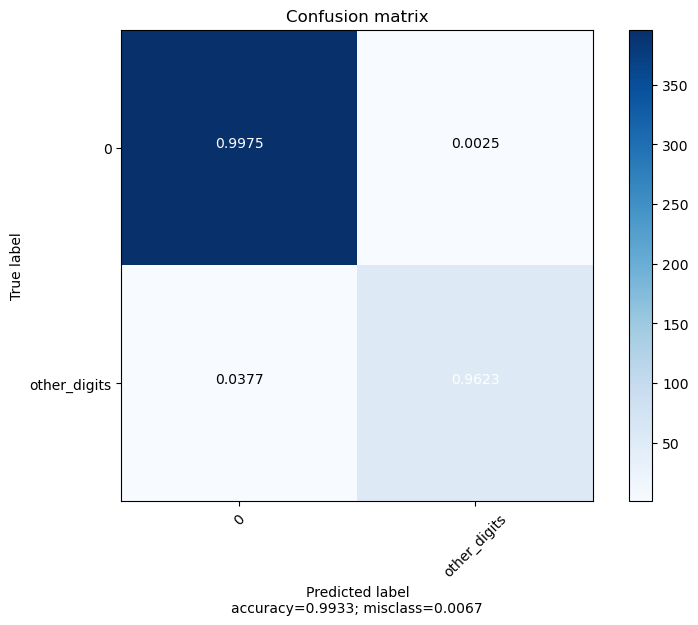

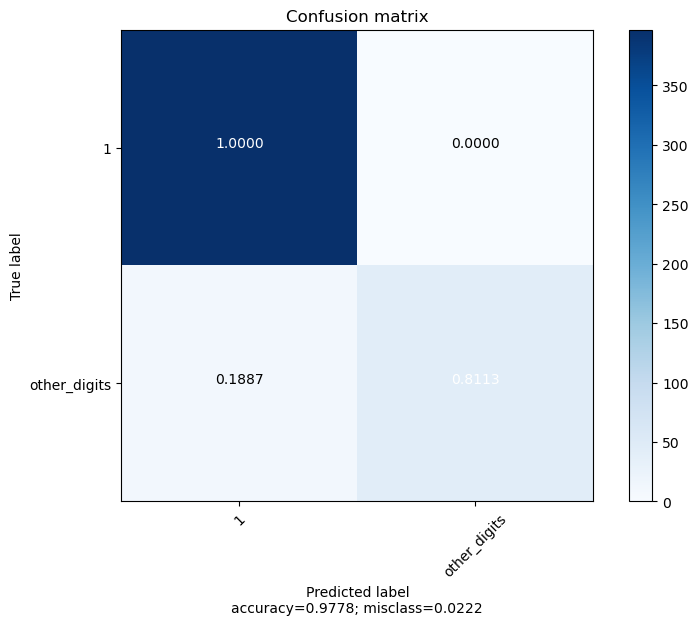

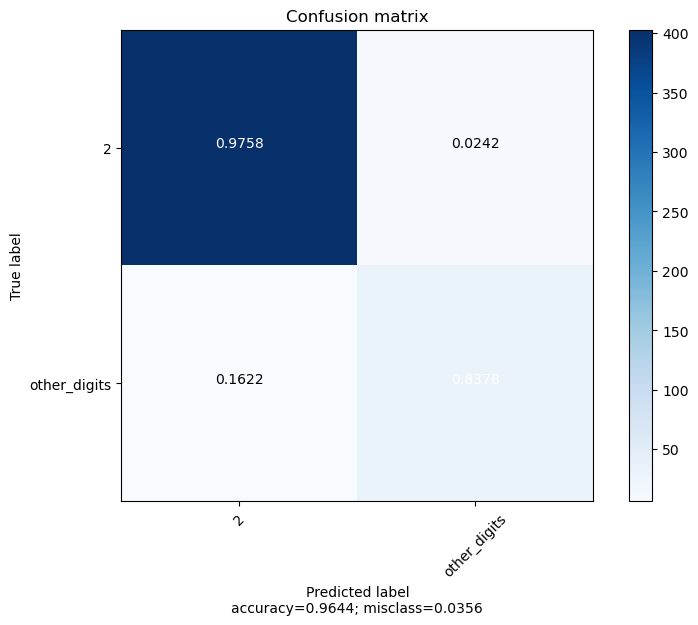

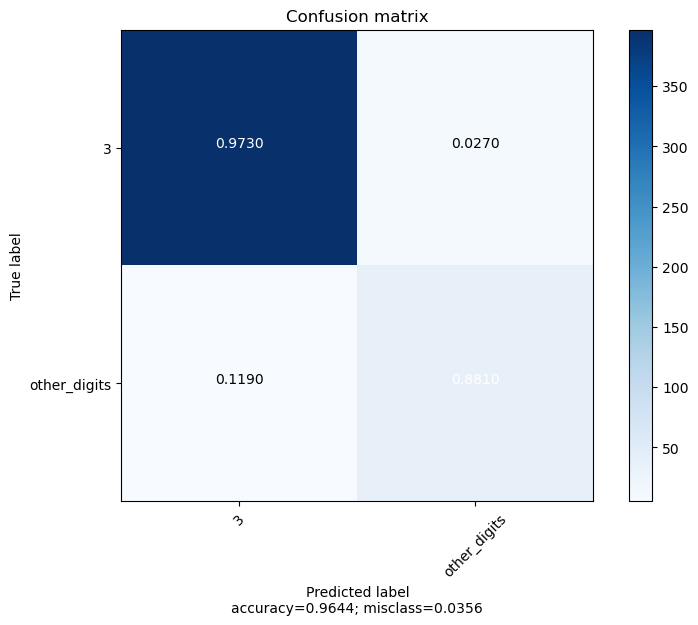

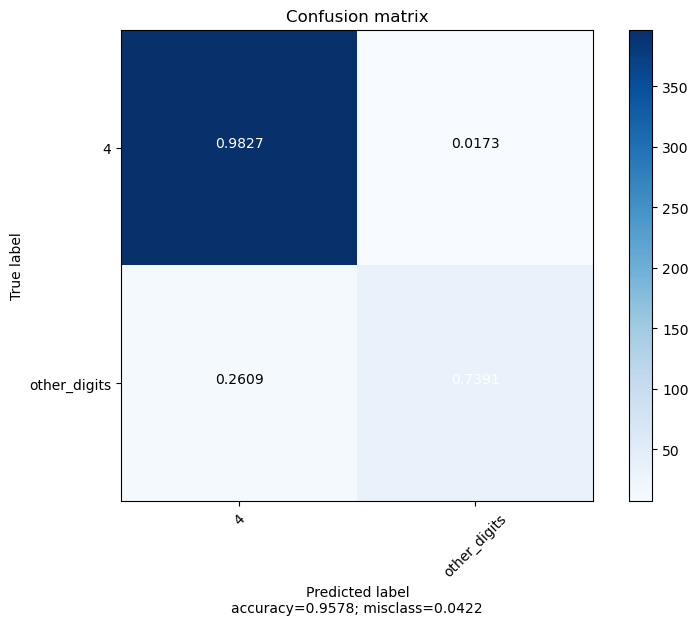

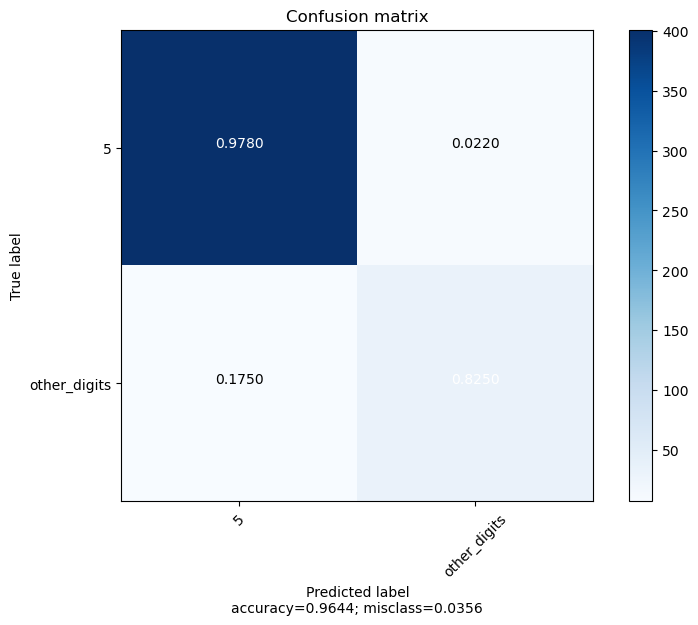

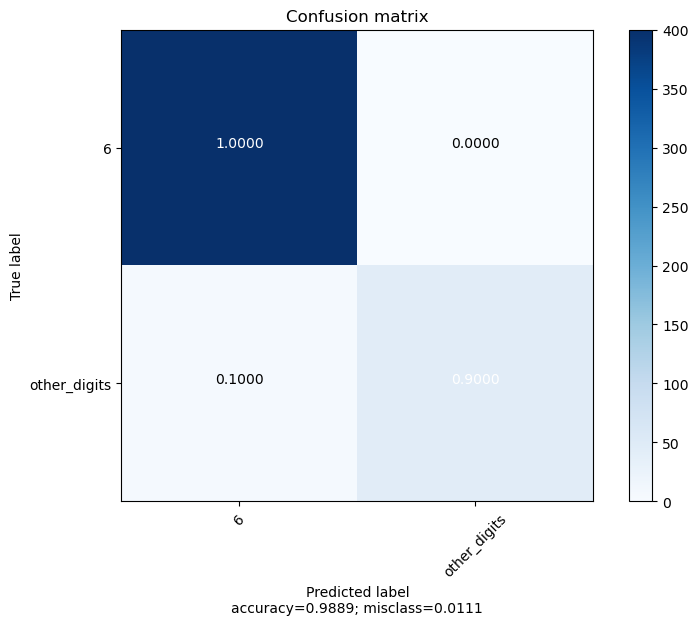

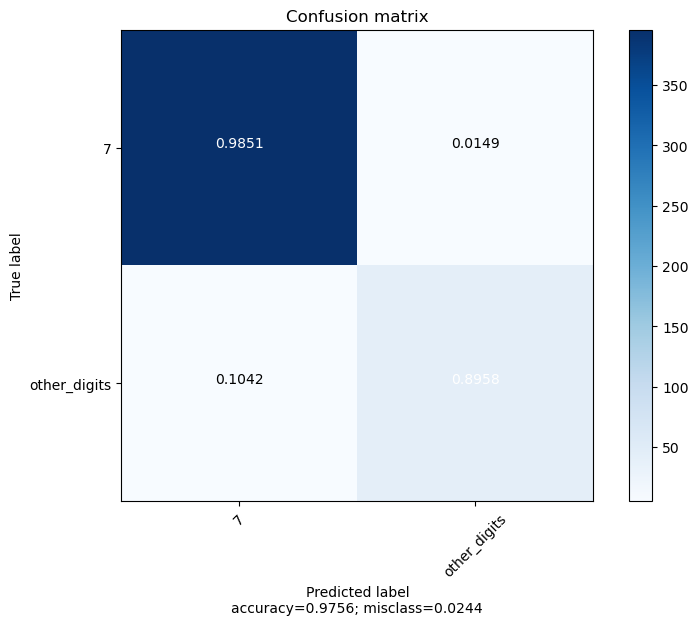

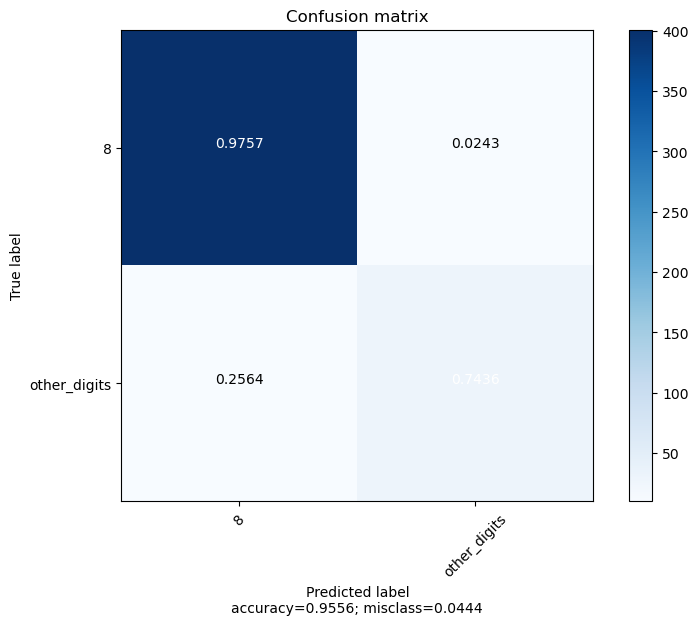

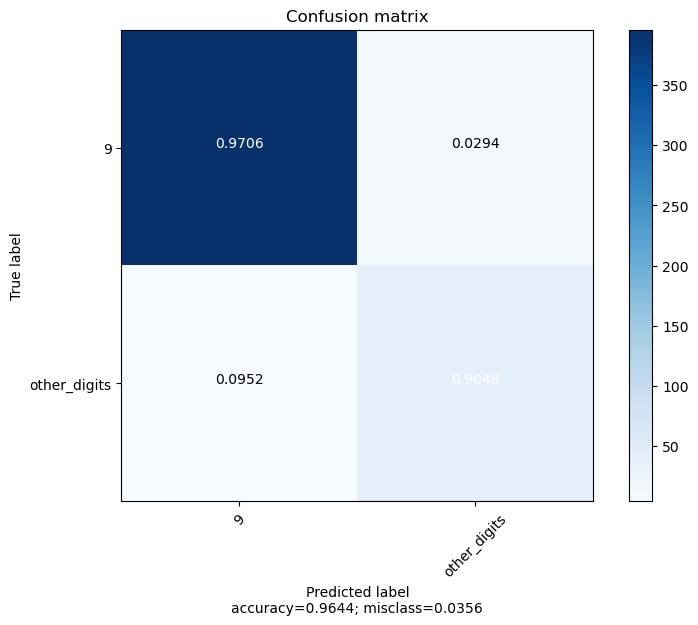

In [123]:
for i, confusion_matrix in enumerate(confusion_matrices):
    plot_confusion_matrix(confusion_matrix, [str(i), "other_digits"])

# One-against-the-rest classification with RegressionForest

In [ ]:
# Train ten one-against-the-rest regression forests for the 10 digits.
# Make sure that all training sets are balanced between the current digit and the rest.
# Assign test instances to the digit with highest score, 
# or to "unknown" if all scores are negative.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
... # your code here